In [ ]:
#!pip install git+https://github.com/tensorflow/examples.git

In [ ]:
#!pip install tensorflow-addons

In [1]:
import tensorflow as tf
#import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
from PIL import Image
import numpy as np
import cv2 as cv

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.experimental.AUTOTUNE

from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow_addons.layers import InstanceNormalization

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LeakyReLU

In [ ]:
x_train = []
y_train = []
x_test = []
y_test = []

folders = ['train/A/trainA', 'train/B/trainB', 'test/A/testA', 'test/B/testB']

for folder in folders:
    image_list = os.listdir(folder)
    for i in image_list:
        path = os.path.join(folder, i)
        image = cv.imread(path)
        #print(image.shape)
        #image = cv.cvtColor(image, cv.COLOR_GRAY2BGR)
        image_tensor = (np.asarray(image))
        if folder == 'train/A/trainA':
            x_train.append(image_tensor)
        elif folder == 'train/B/trainB':
            y_train.append(image_tensor)
        elif folder == 'test/A/testA':
            x_test.append(image_tensor)
        else:
            y_test.append(image_tensor)           
        
dataset = ((x_train, y_train), (x_test, y_test))
np.save('Cycle_split.npy', dataset)

In [2]:
(x_train, y_train), (x_test, y_test) = np.load("Cycle_split.npy",allow_pickle=True)

In [3]:
#dataset, metadata = tfds.load('cycle_gan/horse2zebra',
#                              with_info=True, as_supervised=True)
#
#train_horses, train_zebras = dataset['trainA'], dataset['trainB']
#test_horses, test_zebras = dataset['testA'], dataset['testB']

In [62]:
BUFFER_SIZE = 1000
BATCH_SIZE = 16
IMG_WIDTH = 128
IMG_HEIGHT = 128

In [5]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [6]:
#normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [7]:
def random_jitter(image):
  #resizing to 286 x 286 x 3
  image = tf.image.resize(image, [148, 148],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [8]:
def preprocess_image_train(image):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [9]:
def preprocess_image_test(image):
  image = normalize(image)
  return image

In [10]:
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)
x_test = tf.convert_to_tensor(x_test)
y_test = tf.convert_to_tensor(y_test)

In [11]:
x_train = tf.data.Dataset.from_tensor_slices(x_train)
y_train = tf.data.Dataset.from_tensor_slices(y_train)
x_test = tf.data.Dataset.from_tensor_slices(x_test)
y_test = tf.data.Dataset.from_tensor_slices(y_test)

In [12]:
x_train = x_train.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)

y_train = y_train.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)

x_test = x_test.map(preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)

y_test = y_test.map(preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)

In [42]:
sample_a = next(iter(x_train))

In [30]:
sample_b = next(iter(y_train))

In [15]:
print(sample_b.dtype)

<dtype: 'float32'>


In [16]:
def conv2d_init_block(filters, input_shape=(None, None, 3)):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    input_ = Input(input_shape)
    conv = Conv2D(filters=filters, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=initializer, use_bias=False)(input_)
    act = LeakyReLU()(conv)
    
    return conv, act, input_

In [17]:
def conv2d_block(filters, prev, max_pool):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    conv = Conv2D(filters=filters, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=initializer, use_bias=False)(prev)
    norm = InstanceNormalization()(conv)
    act = LeakyReLU()(norm)
        
    return conv, act

In [18]:
def concat_conv2d_block(filters, prev, concat_layer):
    
    initializer = tf.random_normal_initializer(0., 0.02)
    
    concat = concatenate([Conv2DTranspose(filters=filters, kernel_size=(2, 2), strides=(2, 2), padding='same', kernel_initializer=initializer)(prev), concat_layer], axis=3)
    norm = InstanceNormalization()(concat)
    drop = Dropout(rate=0.5)(norm)
    act = Activation(activation='relu')(drop)
    
    return act

In [19]:
def unet_generator(input_shape=(None, None, 3)):
    
    initializer = tf.random_normal_initializer(0., 0.02)
    
    conv1, res1, input_ = conv2d_init_block(64, input_shape)
    conv2, res2 = conv2d_block(128, res1, True)
    conv3, res3 = conv2d_block(256, res2, True)
    conv4, res4 = conv2d_block(512, res3, True)
    conv5, res5 = conv2d_block(1024, res4, False)


    res6 = concat_conv2d_block(512, res5, conv4)
    res7 = concat_conv2d_block(256, res6, conv3)
    res8 = concat_conv2d_block(128, res7, conv2)
    res9 = concat_conv2d_block(64, res8, conv1)


    conv6 = Conv2DTranspose(filters=OUTPUT_CHANNELS, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=initializer, activation='tanh')(res9)
    model = Model(inputs=[input_], outputs=[conv6])
    
    return model

In [20]:
OUTPUT_CHANNELS = 3

generator_g = unet_generator((IMG_WIDTH, IMG_HEIGHT, OUTPUT_CHANNELS))
generator_f = unet_generator((IMG_WIDTH, IMG_HEIGHT, OUTPUT_CHANNELS))

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


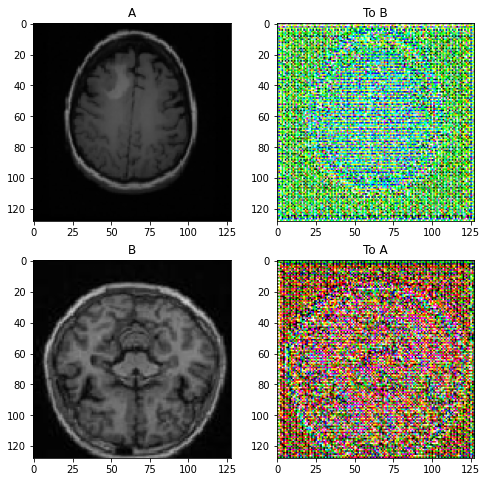

In [43]:
to_b = generator_g(sample_a)
to_a = generator_f(sample_b)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_a, to_b, sample_b, to_a]
title = ['A', 'To B', 'B', 'To A']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

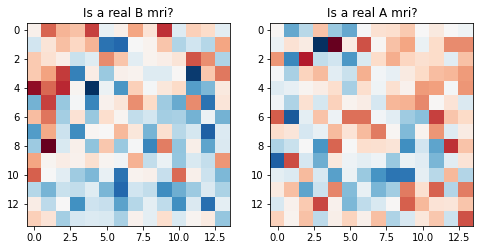

In [44]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real B mri?')
plt.imshow(discriminator_y(sample_b)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real A mri?')
plt.imshow(discriminator_x(sample_a)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [45]:
LAMBDA = 10

In [46]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [47]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [48]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [49]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

In [50]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [51]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [52]:
checkpoint_path = "checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [53]:
EPOCHS = 15

In [54]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [55]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

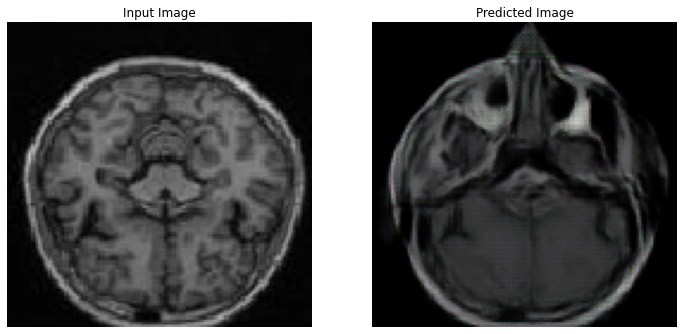

Time taken for epoch 3 is 164.1585340499878 sec

....................................................................................................

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((x_train, y_train)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n+=1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_f, sample_b)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

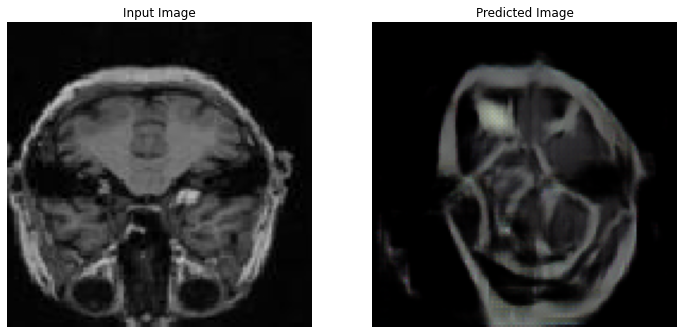

In [61]:
sample_x = next(iter(y_train))
generate_images(generator_f, sample_x)

In [63]:
generator_g.save('gener_g_1.h5')
generator_f.save('gener_f_1.h5')